In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import talib as ta
from talib import abstract
import yfinance as yfin
from arch import arch_model
import os
from datetime import timedelta


pd.set_option('display.float_format', '{:.2f}'.format)


## 資料DataFrame

In [2]:
df = yfin.download('^TWII', start = '2018-1-1', end = '2024-8-10')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

[*********************100%%**********************]  1 of 1 completed


# function & strategy

In [3]:
from llt_strategy_fn import *

# calculate metrics

In [4]:
def calculate_metrics(df, equity, fund, risk_free_rate = 0.04 / 252):
    duration = (equity.index[-1] - equity.index[0]).days
    risk_free_rate = 0.04/252
    equity['equity'] = equity['profitfee'] + fund
    equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
    equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
    profit = equity['profitfee'].iloc[-1]
    ret = equity['equity'].iloc[-1]/equity['equity'].iloc[0] - 1
    mdd = abs(equity['drawdown_percent'].min())
    calmarRatio = ret / mdd
    tradeTimes = min((df['buy'] > 0).sum(), (df['sell'] > 0).sum()) + min((df['sellshort'] > 0).sum(), (df['buytocover'] > 0).sum())
    average_holding_duration = df['hold_duration'].sum() / tradeTimes
    winRate = len([i for i in df['profit_fee_list_realized'] if i > 0]) / tradeTimes
    try:
        profitFactor = sum([i for i in df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in df['profit_fee_list_realized'] if i < 0]))
    except:
        profitFactor = None
    mean_ret = df['profit_list'].mean()
    std_ret = df['profit_list'].std()
    sharp = (mean_ret - risk_free_rate) / std_ret

    metrics = {
        'duration' :  duration,
        'average_holding_duration': average_holding_duration,
        'profit': profit,
        'return': ret,
        'max_drawdown': mdd,
        'caimar_ratio': calmarRatio,
        'trade_times': tradeTimes,
        'win_rate': winRate,
        'profit_factor': profitFactor,
        'sharp_ratio': sharp
    }

    return metrics

# optimize

In [5]:
def optimize(strategy_fn, a_range, distance_threshold_range, retrace_threshold_range, df, fund, feePaid, p = 1, q = 1, rolling = 20, num_vol = 1):
    
    results = []

    for a in a_range:
        for distance_threshold in distance_threshold_range:
            for retrace_threshold in retrace_threshold_range:
                df_copy = df.copy()
                df, equity = strategy_fn(
                    df_copy, feePaid, a = a, p = p, q = q, rolling = rolling, num_vol = num_vol,
                    distance_threshold = distance_threshold, retrace_threshold = retrace_threshold)

                metrics = calculate_metrics(df, equity, fund)

                result = {
                    'a': a,
                    'p': p,
                    'q': q,
                    'num_vol': num_vol,
                    'rolling': rolling,
                    'distance_threshold': distance_threshold,
                    'retrace_threshold': retrace_threshold,
                    'duration' :  metrics['duration'],
                    'average_holding_duration': metrics['average_holding_duration'],
                    'profit': metrics['profit'],
                    'return': metrics['return'],
                    'max_drawDown': metrics['max_drawdown'],
                    'caimar_ratio': metrics['caimar_ratio'],
                    'trade_times': metrics['trade_times'],
                    'win_rate': metrics['win_rate'],
                    'profit_factor': metrics['profit_factor'],
                    'sharp_ratio': metrics['sharp_ratio']
                }
                results.append(result)
                print(f'a: {a}, distance_threshold: {distance_threshold}, retrace_threshold: {retrace_threshold}')
                
    results_df = pd.DataFrame(results)
    results_df.to_csv('results_df.csv')
    return results_df

# parametors

In [6]:
strategy_fn = llt_strategy
a = np.arange(0.1, 1, 0.05)
p = 1
q = 1
num_vol = 1
rolling = 20
distance_threshold = np.arange(0.01, 0.15, 0.02)
retrace_threshold = np.arange(0.01, 0.15, 0.02)
fund = 1000000
feePaid = 600
optimize_indicator = 'return'
insample_ranges = [
    ('2018-01-01', '2018-12-31'),
    ('2018-07-08', '2019-07-07'),
    ('2019-01-12', '2020-01-11'),
    ('2019-07-19', '2020-07-17'),
    ('2020-01-23', '2021-01-21'),
    ('2020-07-29', '2021-07-28'),
    ('2021-02-02', '2022-02-01'),
    ('2021-08-09', '2022-08-08'),
    ('2022-02-23', '2023-02-12'),
    ('2022-08-20', '2023-08-19')]
outsample_range = [
    ('2018-12-31', '2019-07-07'),
    ('2019-07-07', '2020-01-11'),
    ('2020-01-11', '2020-07-17'),
    ('2020-07-17', '2021-01-21'),
    ('2021-01-21', '2021-07-28'),
    ('2021-07-28', '2022-02-01'),
    ('2022-02-21', '2022-08-08'),
    ('2022-08-08', '2023-02-12'),
    ('2023-02-12', '2023-08-19'),
    ('2023-08-19', '2024-03-01')
    ]

# execute

In [7]:
'''
results_df = optimize(
    strategy_fn = strategy_fn, a_range = a,
    upper_threshold_range = upper_threshold, lower_threshold_range = lower_threshold,
    retrace_u_threshold_range = retrace_u_threshold, retrace_l_threshold_range = retrace_l_threshold,
    deviation_threshold = deviation_threshold, distance_threshold_range = distance_threshold, drawdown_range = drawdown,
    df = df, fund = fund, feePaid = feePaid, p = p, q = q, rolling = rolling, num_vol = num_vol)
'''

'\nresults_df = optimize(\n    strategy_fn = strategy_fn, a_range = a,\n    upper_threshold_range = upper_threshold, lower_threshold_range = lower_threshold,\n    retrace_u_threshold_range = retrace_u_threshold, retrace_l_threshold_range = retrace_l_threshold,\n    deviation_threshold = deviation_threshold, distance_threshold_range = distance_threshold, drawdown_range = drawdown,\n    df = df, fund = fund, feePaid = feePaid, p = p, q = q, rolling = rolling, num_vol = num_vol)\n'

# extract

In [8]:

def extract_best_params(results_df, optimize_indicator, ascending = False):
    sorted_df = results_df.sort_values(by = optimize_indicator, ascending = ascending)
    best_params = sorted_df.iloc[0].to_dict()
    return best_params
'''
best_params = extract_best_params(results_df = results_df, optimize_indicator = 'sharp_ratio')

results_df.to_csv('test.csv')
best_params
'''

"\nbest_params = extract_best_params(results_df = results_df, optimize_indicator = 'sharp_ratio')\n\nresults_df.to_csv('test.csv')\nbest_params\n"

# 純手工 moving window

In [9]:

def optimize_by_date_range(df, optimize_fn, optimize_indicator, date_ranges, ascending = False):
    results = []
    for start_date, end_date in date_ranges:
        print(f'=================\n{start_date}, {end_date}\n====================')
        period_df = df[(df.index >= start_date) & (df.index <= end_date)]
        
        if period_df.empty:
            print(f"No data for period {start_date} to {end_date}")
            continue
        
        results_df = optimize_fn(
            llt_strategy, a_range = a,
            distance_threshold_range = distance_threshold,
            retrace_threshold_range = retrace_threshold,
            df = period_df, fund = fund, feePaid = feePaid, p = p, q = q, rolling = rolling, num_vol = num_vol
        )
        
        best_params = extract_best_params(results_df, optimize_indicator, ascending)
        best_params['start_date'] = start_date
        best_params['end_date'] = end_date
        results.append(best_params)
    
    return pd.DataFrame(results)


In [10]:

params_df = optimize_by_date_range(
    df, optimize, optimize_indicator, date_ranges = insample_ranges)


params_df.to_csv('params_df.csv')


2018-01-01, 2018-12-31


KeyError: 'lly_slope'

# put best_params in

In [ ]:
def run_strategy_on_dates(params_df, outsample_ranges, strategy_fn, df, feePaid):
    all_df = []
    all_equity = []

    for i, (start_date, end_date) in enumerate(outsample_ranges):
        
        param = params_df.iloc[i]
        date_range_df = df.loc[start_date : end_date]
        a = param['a']
        p = 1
        q = 1
        num_vol = 1
        rolling = 20
        distance_threshold = param['distance_threshold']
        retrace_threshold = param['retrace_threshold']
        feePaid = 600

        full_df, full_equity = strategy_fn(
            df = date_range_df,
            feePaid = feePaid,
            a = a, p = p, q = q, num_vol = num_vol, rolling = rolling,
            distance_threshold = distance_threshold, retrace_threshold = retrace_threshold)
        
        all_df.append(full_df)
        all_equity.append(full_equity)

    combined_df = pd.concat(all_df)
    combined_equity = pd.concat(all_equity)

    combined_df['strategy_ret'] = combined_df['profit_list'].cumsum()
    combined_equity['profitfee'] = combined_df['profit_fee_list'].cumsum()

    return combined_df, combined_equity

full_df, full_equity = run_strategy_on_dates(params_df, outsample_range, llt_strategy, df, feePaid = 600)
full_df.to_csv('full_df.csv')
full_equity.to_csv('full_equity.csv')


/Users/xinc./Documents/GitHub/Quant_idea/TMBA/llt_strategy_fn.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['llt'] = llt
/Users/xinc./Documents/GitHub/Quant_idea/TMBA/llt_strategy_fn.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['llt_slope'] = np.nan
/Users/xinc./Documents/GitHub/Quant_idea/TMBA/llt_strategy_fn.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [ ]:
print('------------------------------Total----------------------------------')
get_performance(full_df, full_equity)

------------------------------Total----------------------------------
Duration :  1885 days
Average holding duration 8.96551724137931 days
Profit :  959121.484375
Return :  0.959121484375
Max DrawDown :  0.41335446938701303
Caimar Ratio :  2.3203365522993766
Trade Times :  87
Win Rate :  0.25287356321839083
Profit Factor :  0.9873721015475535
Sharp Ratio :  0.039759806995954314


In [ ]:
full_df['index_ret'] = np.zeros(len(full_df))

for i in range(1, len(full_df)):
    full_df.loc[full_df.index[i], 'index_ret'] = (full_df['open'].iloc[i] - full_df['open'].iloc[i - 1]) * 200

full_df['cum_index_ret'] = full_df['index_ret'].cumsum()

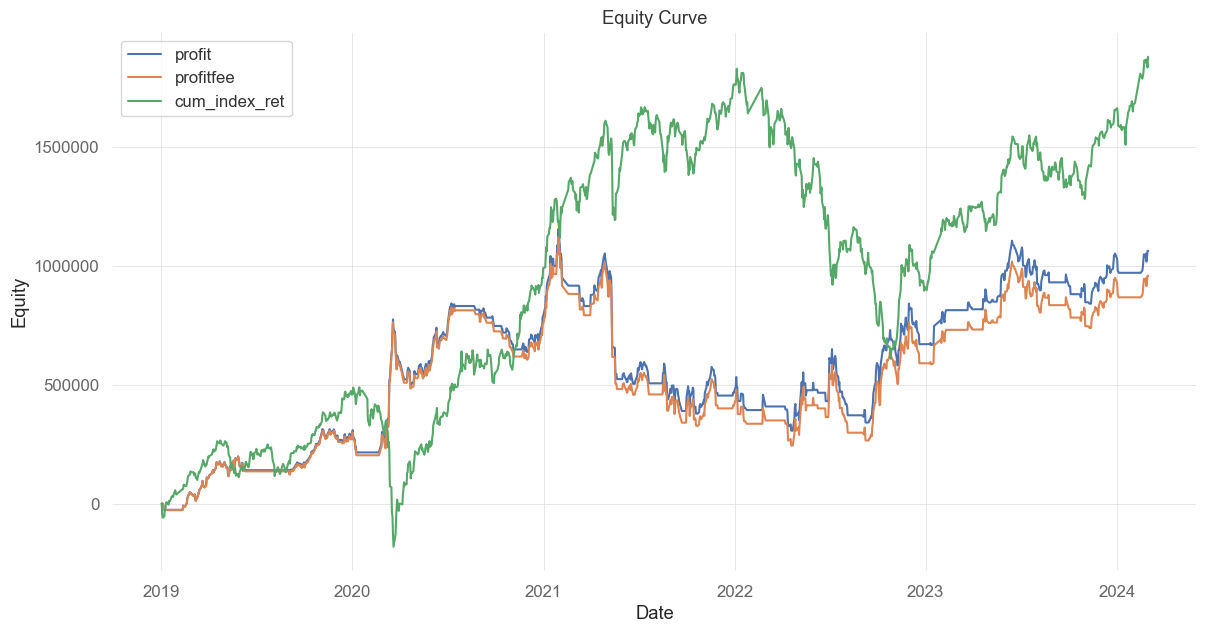

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(full_df.index, full_df['strategy_ret'], label='profit')
ax.plot(full_df.index, full_equity['profitfee'], label='profitfee')
ax.plot(full_df.index, full_df['cum_index_ret'], label='cum_index_ret')

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.set_title('Equity Curve')
ax.legend()

plt.show()


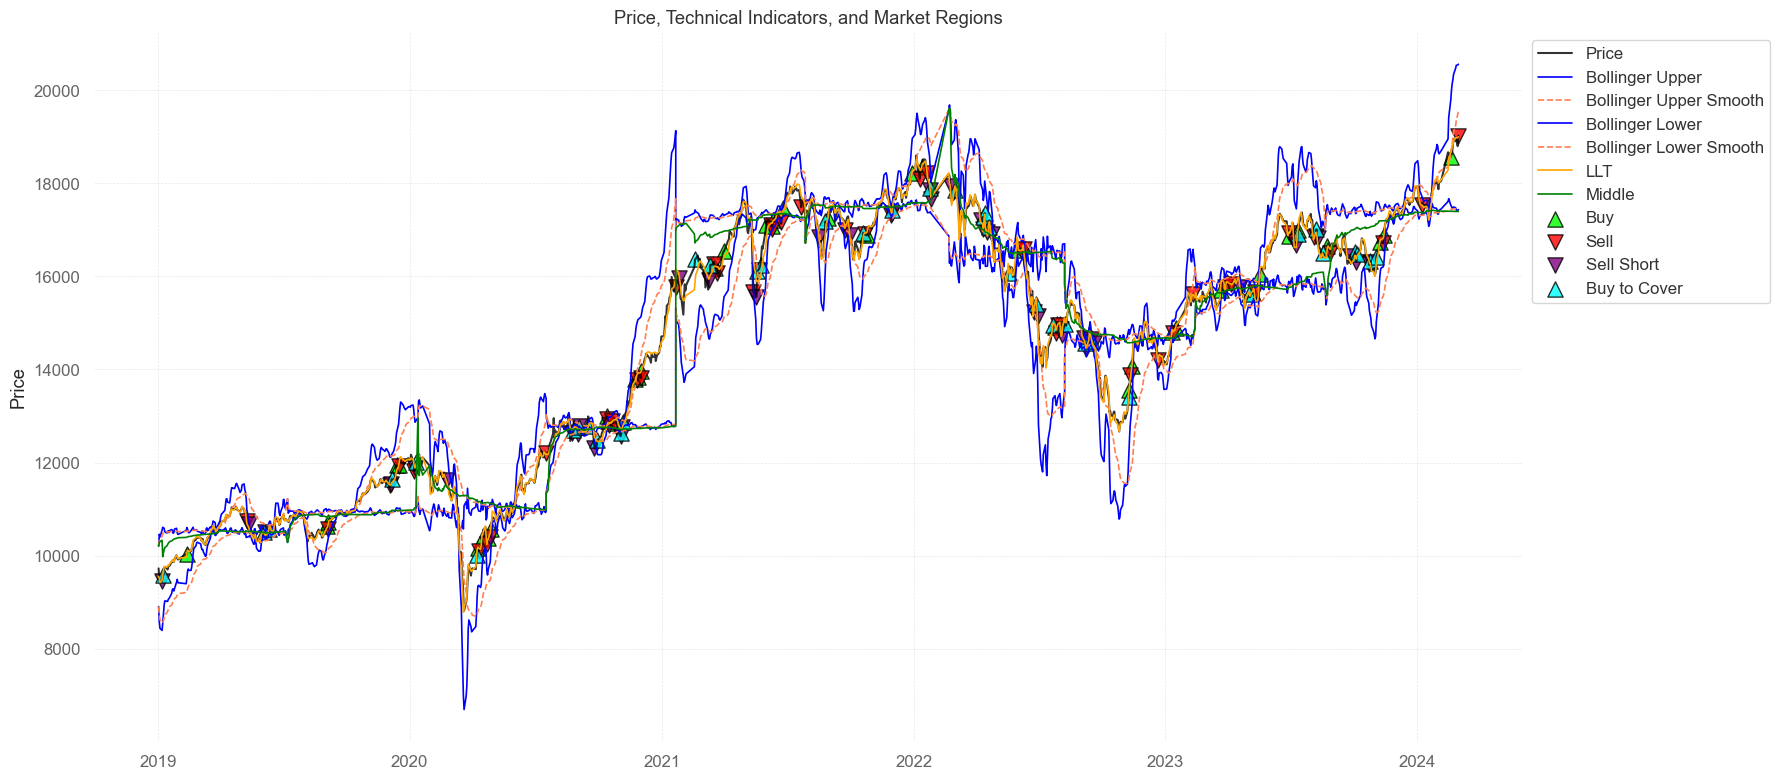

In [ ]:
buy_points = full_df[full_df['buy'] != 0]
sell_points = full_df[full_df['sell'] != 0]
sellshort_points = full_df[full_df['sellshort'] != 0]
buytocover_points = full_df[full_df['buytocover'] != 0]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), sharex=True)

ax1.plot(full_df.index, full_df['open'], label='Price', color='black', alpha=0.8, linewidth=1.5)

ax1.plot(full_df.index, full_df['bolinger_upper'], label='Bollinger Upper', color='blue', linewidth=1.2)
ax1.plot(full_df.index, full_df['bolinger_upper_smooth'], label='Bollinger Upper Smooth', color='coral', linestyle='--', linewidth=1.2)

ax1.plot(full_df.index, full_df['bolinger_lower'], label='Bollinger Lower', color='blue', linewidth=1.2)
ax1.plot(full_df.index, full_df['bolinger_lower_smooth'], label='Bollinger Lower Smooth', color='coral', linestyle='--', linewidth=1.2)

ax1.plot(full_df.index, full_df['llt'], label='LLT', color='orange', linewidth=1.2)
ax1.plot(full_df.index, full_df['middle'], label='Middle', color='green', linewidth=1.2)

ax1.scatter(buy_points.index, buy_points['open'].loc[buy_points.index], color='lime', edgecolor='black', marker='^', label='Buy', s=120, alpha=0.8)
ax1.scatter(sell_points.index, sell_points['open'].loc[sell_points.index], color='red', edgecolor='black', marker='v', label='Sell', s=120, alpha=0.8)
ax1.scatter(sellshort_points.index, sellshort_points['open'].loc[sellshort_points.index], color='purple', edgecolor='black', marker='v', label='Sell Short', s=120, alpha=0.8)
ax1.scatter(buytocover_points.index, buytocover_points['open'].loc[buytocover_points.index], color='cyan', edgecolor='black', marker='^', label='Buy to Cover', s=120, alpha=0.8)

# # 畫趨勢區域
# bull_region_label_shown = False
# bear_region_label_shown = False
# consolidation_region_label_shown = False
# for i in range(1, len(full_df)):
#     if full_df['Bull'].iloc[i]:
#         ax1.axvspan(full_df.index[i-1], full_df.index[i], color='lightgreen', alpha=0.5, label='Bull Region' if not bull_region_label_shown else "")
#         bull_region_label_shown = True
#     if full_df['Bear'].iloc[i]:
#         ax1.axvspan(full_df.index[i-1], full_df.index[i], color='lightcoral', alpha=0.5, label='Bear Region' if not bear_region_label_shown else "")
#         bear_region_label_shown = True
    
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.set_title('Price, Technical Indicators, and Market Regions')
ax1.set_ylabel('Price')
ax1.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


                           Strategy
-------------------------  ----------
Start Period               2019-01-03
End Period                 2024-03-01
Risk-Free Rate             0.0%
Time in Market             59.0%

Cumulative Return          95.91%
CAGR﹪                     9.41%

Sharpe                     0.73
Prob. Sharpe Ratio         94.85%
Smart Sharpe               0.65
Sortino                    1.1
Smart Sortino              0.97
Sortino/√2                 0.78
Smart Sortino/√2           0.69
Omega                      1.18

Max Drawdown               -41.34%
Longest DD Days            1125
Volatility (ann.)          21.99%
Calmar                     0.23
Skew                       0.38
Kurtosis                   9.37

Expected Daily %           0.05%
Expected Monthly %         1.07%
Expected Yearly %          11.86%
Kelly Criterion            8.22%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.22%
Expected Shortfall (cVaR)  -2.22%

Max Consecutive Wins       

/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-01,2022-04-19,2024-03-01,1125,-41.34,-40.05
2,2020-03-20,2020-04-21,2020-07-02,105,-15.77,-15.39
3,2020-07-10,2020-11-30,2021-01-04,179,-12.03,-11.84
4,2019-11-20,2020-01-09,2020-03-06,108,-7.95,-6.29
5,2019-05-29,2019-09-03,2019-10-09,134,-6.24,-5.15


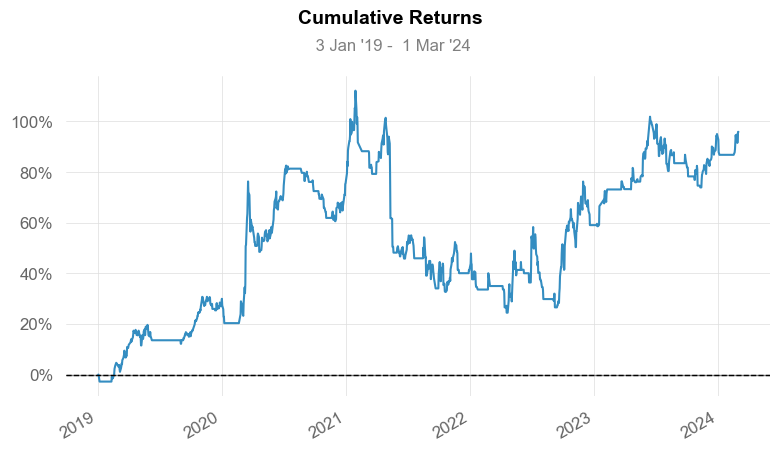

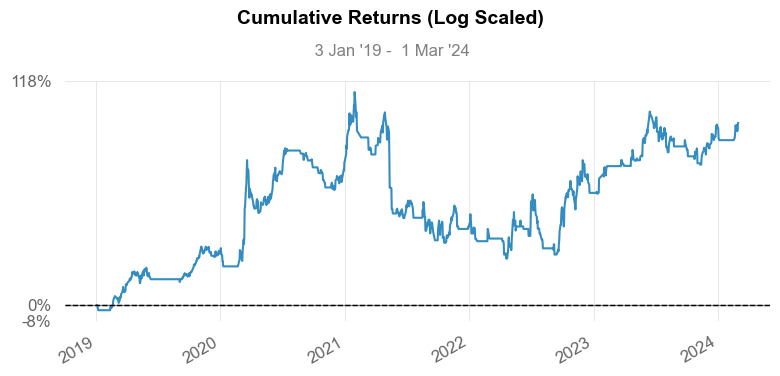

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


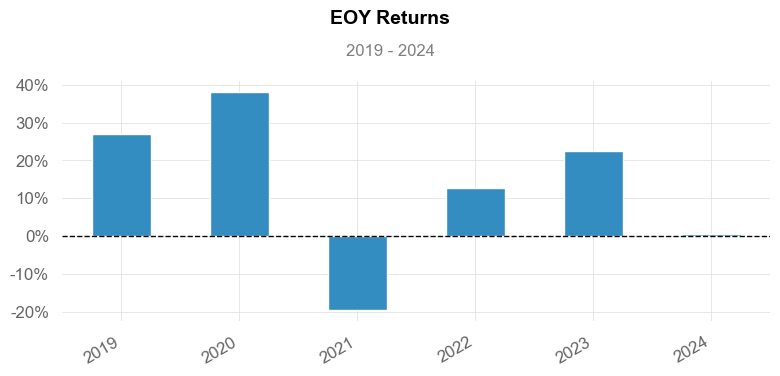

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


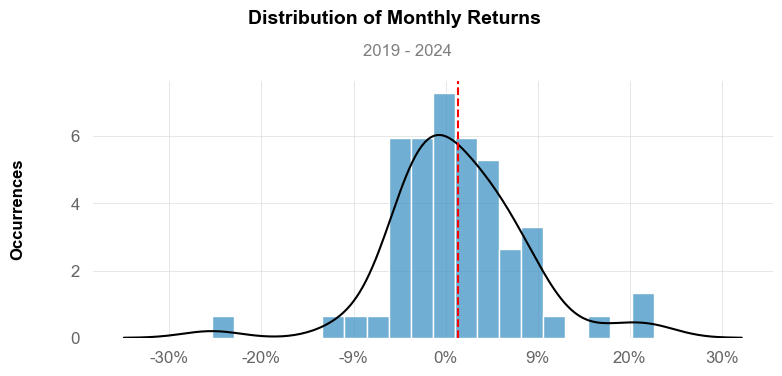

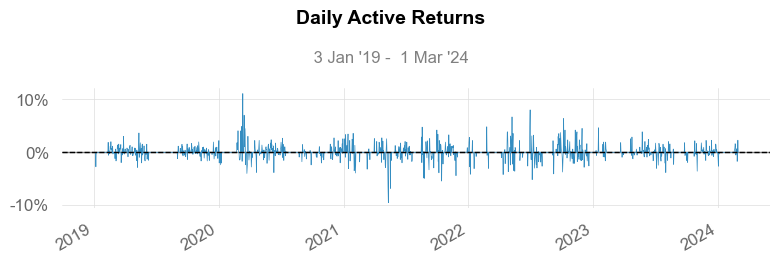

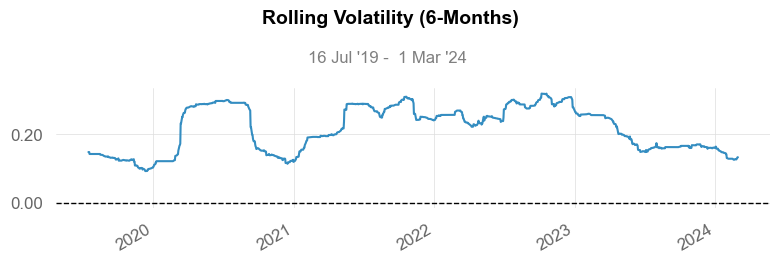

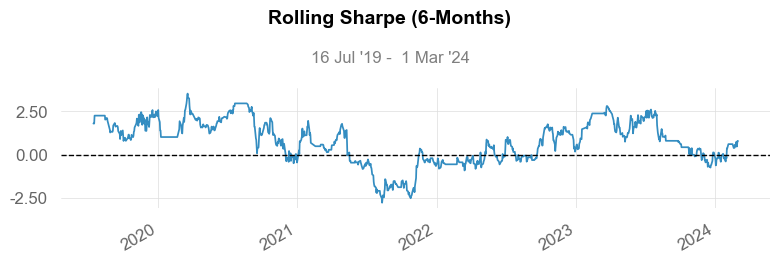

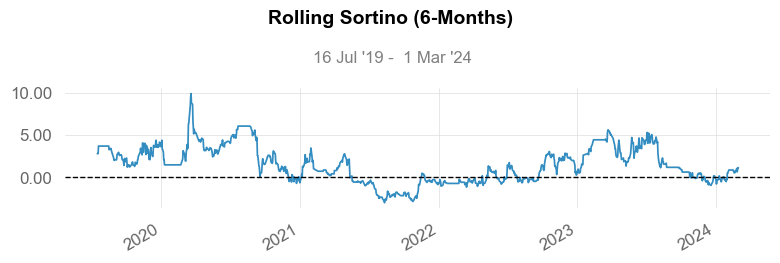

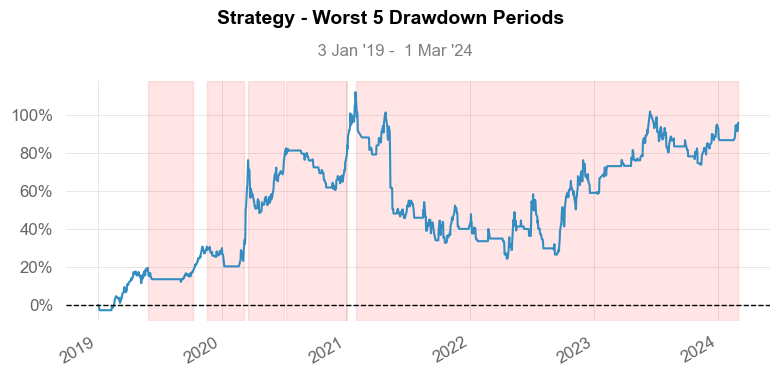

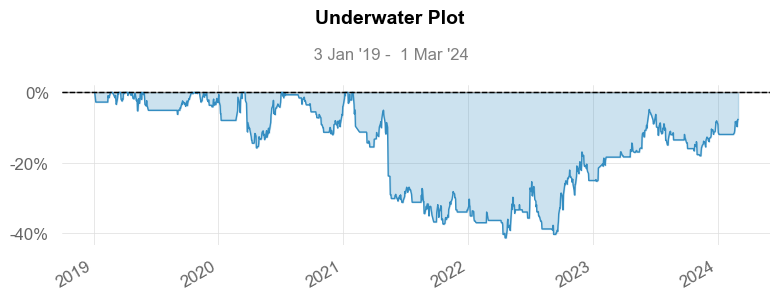

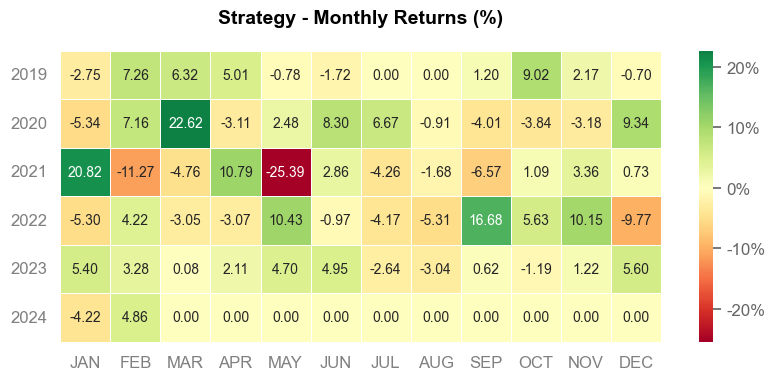

/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/Users/xinc./Library/Python/3.9/lib/python/site-packages/quantstats/_plotting/core.py:1019: FutureWarni

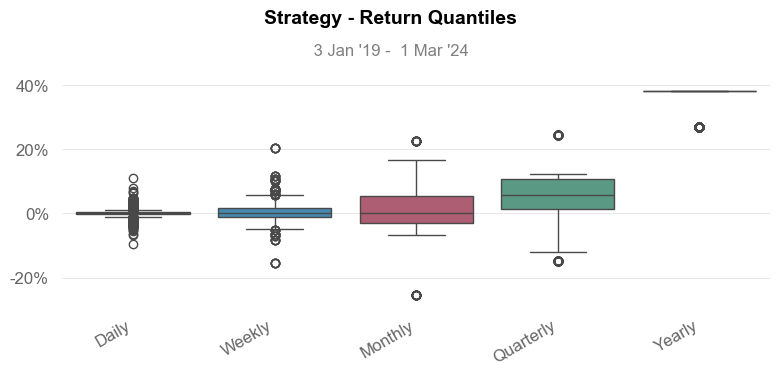

In [ ]:
ret = full_equity['equity'].pct_change(periods=1).dropna()
quantstats.reports.full(ret)